In [1]:
from datetime import datetime

In [2]:
from noteLib import *

In [3]:
from lilcubeLib.lc_api import Lilcube


lc = Lilcube()

creating Lilcube class


In [4]:
left,bottom,right,top = (30.209661,-2.218817,30.246396,-2.163926)

In [5]:
ul_lat = top
ul_lon = left

lr_lat = bottom
lr_lon = right

aoi_ul_geo = (ul_lat, ul_lon)
aoi_lr_geo = (lr_lat, lr_lon)

date_range = (datetime(2013,7,6), datetime(2013,7,7))
# date_range = (datetime(2013,7,6), datetime(2018,7,7))

es_index = 'datacube'
es_type = 'rwanda'

dsets = lc.search(es_index, es_type, aoi_ul_geo, aoi_lr_geo,
             time = date_range, measurements = ('red', 'green', 'blue','nir') )

(datetime.datetime(2013, 7, 6, 0, 0), datetime.datetime(2013, 7, 7, 0, 0))
2013-07-06


In [6]:
lats = (top,bottom)
lons = (left,right)
m = display_map(lats,lons)

In [7]:
m

![lake rumira](http://1.bp.blogspot.com/-1VYQ3gjzLOg/T_m-HmfYqPI/AAAAAAAAADA/cWGE_sDudcE/s1600/lake+rumira.JPG)

In [8]:
# query practice

In [9]:
from lilcubeLib.lc_geometry import return_aoi_polygon

geojson_polygon = return_aoi_polygon(aoi_ul_geo, aoi_lr_geo)
geojson_polygon

{"coordinates": [[-2.163926, 30.209661], [-2.163926, 30.246396], [-2.218817, 30.246396], [-2.218817, 30.209661], [-2.163926, 30.209661]], "type": "Polygon"}

In [10]:
from lilcubeLib.lc_elastic import return_geo_query_body

mybody = return_geo_query_body(aoi_ul_geo, aoi_lr_geo, time = date_range)

In [11]:
mybody

{'query': {'bool': {'filter': [{'geo_shape': {'footprint': {'shape': {'coordinates': [[[-2.163926,
           30.209661],
          [-2.163926, 30.246396],
          [-2.218817, 30.246396],
          [-2.218817, 30.209661],
          [-2.163926, 30.209661]]],
        'type': 'Polygon'}}}}],
   'must': [{'range': {'creation_dt': {'gte': '2013-07-06'}}},
    {'range': {'creation_dt': {'lt': '2013-07-07'}}}]}}}

In [12]:
from elasticsearch import Elasticsearch
from dcindexLib.elastic_index import connect_elasticsearch

#client = Elasticsearch()

client = connect_elasticsearch()

# print(help(client.search))

response = client.search(
    index="datacube",size=1400,
    body=mybody)

Yay Connect


In [13]:
cnt = 0
dt_list = []
file_list = []
for hit in response['hits']['hits']:
    print(hit['_score'], hit['_source']['red'])
    print(hit['_source']['creation_dt'])

    file_list.append(hit['_source']['red'])
    dt_list.append(hit['_source']['creation_dt'])
    cnt = cnt + 1
    print("CNT=",cnt)

2.0 /mnt/rwanda/LC08/172/061/2013/LC081720612013070601T1-SC20181130015946/LC08_L1TP_172061_20130706_20170503_01_T1_sr_band4.tif
2013-07-06
CNT= 1
2.0 /mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band4.tif
2013-07-06
CNT= 2


In [14]:
help(datetime.date)
t0 = str(datetime.date(date_range[0]))
    
t0

Help on method_descriptor:

date(...)
    Return date object with same year, month and day.



'2013-07-06'

In [15]:
#response

len(response['hits']['hits'])

2

In [16]:
#import glob
#import pandas as pd
import xarray as xr


time = xr.Variable('time', dt_list)
chunks = {'x': 256, 'y': 256, 'band': 1}
da = xr.concat([xr.open_rasterio(f,chunks=chunks) for f in file_list], dim=time)

/usr/local/lib/python3.5/dist-packages/dask/array/core.py:3222: PerformanceWarning: Increasing number of chunks by factor of 30
  **atop_kwargs)


In [17]:
da


<xarray.DataArray (time: 2, band: 1, y: 13071, x: 8711)>
dask.array<shape=(2, 1, 13071, 8711), dtype=float64, chunksize=(1, 1, 51, 256)>
Coordinates:
  * y        (y) float64 -4.362e+05 -4.362e+05 ... -4.413e+04 -4.41e+04
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.813e+05 3.813e+05
  * band     (band) int64 1
  * time     (time) <U10 '2013-07-06' '2013-07-06'
Attributes:
    crs:         +init=epsg:32636
    is_tiled:    1
    res:         (30.0, 30.0)
    nodatavals:  (-9999.0,)

In [18]:
my_arr = da[0]
my_arr

<xarray.DataArray (band: 1, y: 13071, x: 8711)>
dask.array<shape=(1, 13071, 8711), dtype=float64, chunksize=(1, 51, 256)>
Coordinates:
  * y        (y) float64 -4.362e+05 -4.362e+05 ... -4.413e+04 -4.41e+04
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.813e+05 3.813e+05
  * band     (band) int64 1
    time     <U10 '2013-07-06'
Attributes:
    crs:         +init=epsg:32636
    is_tiled:    1
    res:         (30.0, 30.0)
    nodatavals:  (-9999.0,)

In [19]:
val = my_arr['band'].values

In [20]:
val

array([1])

In [21]:
my_arr.shape

(1, 13071, 8711)

In [22]:
arr = my_arr[0, 2000:2005, 2000:2005].values

In [23]:
arr

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [24]:
arr.shape

(5, 5)

In [25]:
arr2 = da.sel(band=1)[0]


In [26]:
arr2.shape

(13071, 8711)

In [27]:
type(arr2)

xarray.core.dataarray.DataArray

In [28]:
arr3 = arr2[2000:3000:8, 2000:3000:8].values

In [29]:
arr3.shape

(125, 125)

In [30]:
type(arr3)

numpy.ndarray

In [31]:
#arr3.plot.imshow()

In [32]:
arr3.shape

(125, 125)

In [33]:
#npa

In [34]:
img_toshow = exposure.equalize_hist(arr3, mask = np.isfinite(arr3))

/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:129: RuntimeWarning: invalid value encountered in true_divide
  img_cdf = img_cdf / float(img_cdf[-1])


/usr/local/lib/python3.5/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.5/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.5/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/tony/.local/lib/python3.5/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


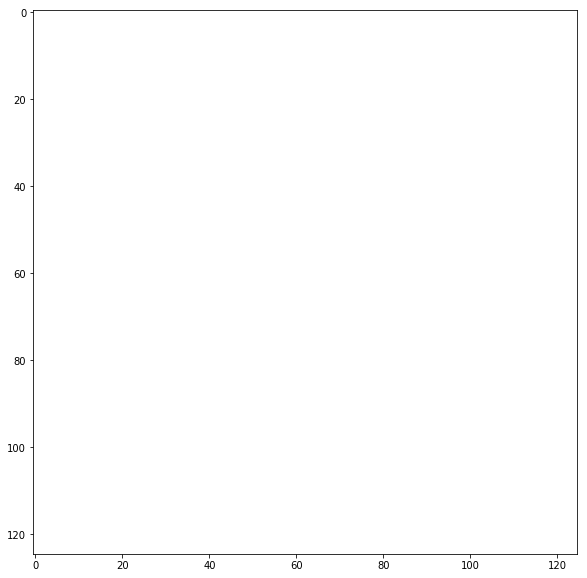

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

fig1 = plt.figure(figsize=(10,10))
imgplot = plt.imshow(img_toshow)

In [36]:
arr3

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [37]:
# https://www.youtube.com/watch?v=7YvKhcs7sb0

# Numpy Array Slicing - Tutorial on Array Slicing in Numpy

In [38]:
# https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/landsat8-cog-ndvi.ipynb

In [39]:
myfile = file_list[1]

In [40]:
myfile

'/mnt/rwanda/LC08/172/062/2013/LC081720622013070601T1-SC20181129211703/LC08_L1TP_172062_20130706_20170503_01_T1_sr_band4.tif'

In [41]:
import rasterio
with rasterio.open(myfile) as src:
    print(src.profile)

{'width': 7581, 'transform': Affine(30.0, 0.0, 119985.0,
       0.0, -30.0, -204285.0), 'count': 1, 'crs': CRS({'init': 'epsg:32636'}), 'dtype': 'int16', 'blockysize': 256, 'nodata': -9999.0, 'interleave': 'band', 'height': 7731, 'blockxsize': 256, 'compress': 'deflate', 'tiled': True, 'driver': 'GTiff'}


In [42]:
# Note that the blocksize of the image is 256 by 256, so we want xarray to use some multiple of that
xchunk = 2048
ychunk = 2048
da = xr.open_rasterio(myfile, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

<xarray.DataArray (band: 1, y: 7731, x: 7581)>
dask.array<shape=(1, 7731, 7581), dtype=int16, chunksize=(1, 2048, 2048)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
Attributes:
    crs:         +init=epsg:32636
    is_tiled:    1
    res:         (30.0, 30.0)
    transform:   (30.0, 0.0, 119985.0, 0.0, -30.0, -204285.0)
    nodatavals:  (-9999.0,)

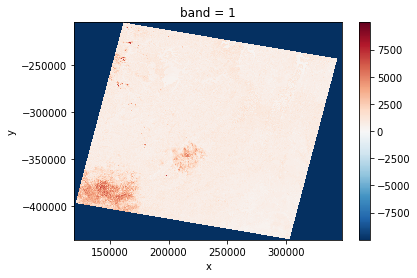

In [43]:
da.sel(band=1).plot.imshow()

In [44]:
arr2 = da.sel(band=1)

In [45]:
arr2

<xarray.DataArray (y: 7731, x: 7581)>
dask.array<shape=(7731, 7581), dtype=int16, chunksize=(2048, 2048)>
Coordinates:
    band     int64 1
  * y        (y) float64 -2.043e+05 -2.043e+05 ... -4.362e+05 -4.362e+05
  * x        (x) float64 1.2e+05 1.2e+05 1.201e+05 ... 3.474e+05 3.474e+05
Attributes:
    crs:         +init=epsg:32636
    is_tiled:    1
    res:         (30.0, 30.0)
    transform:   (30.0, 0.0, 119985.0, 0.0, -30.0, -204285.0)
    nodatavals:  (-9999.0,)

In [46]:
arr2.shape

(7731, 7581)

In [47]:
arr3 = arr2[2000:2200, 2000:2200]

In [48]:
arr3.shape

(200, 200)

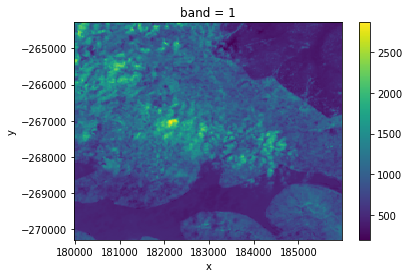

In [49]:
arr3.plot.imshow()

In [50]:
#(2320, 1172, 137, 204))

In [51]:
arr3 = arr2[1172:1372, 2320:2520]

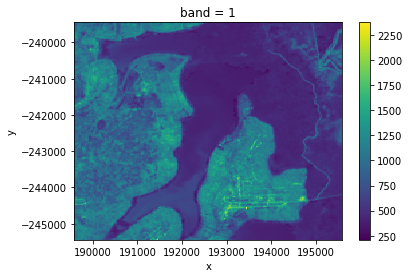

In [52]:
arr3.plot.imshow()

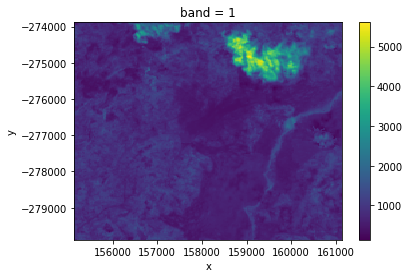

In [53]:
# arr3 = arr2[1172:1372, 2320:2520]
arr3 = arr2[2320:2520, 1172:1372]
arr3.plot.imshow()